In [1]:
import numpy as np
import random
import os

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import tensorflow as tf 

tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [2]:
from plot_module import save_plot

import pandas as pd
import matplotlib.pyplot as plt 

from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

### Loading data and preprocessing

In [3]:
df = pd.read_csv('Monthly_oil_data.csv', index_col='Production Date', parse_dates=True)
df['LogVolume'] = np.log(df['Volume']) 
df['DiffLogVolume'] = df['LogVolume'].diff() 
df.head()

,Volume,LogVolume,DiffLogVolume
Production Date,,,
2015-01-01,67515553.0,18.027869,NaN
2015-02-01,61664960.0,17.937226,-0.090642
2015-03-01,66342950.0,18.010348,0.073122
2015-04-01,67719040.0,18.030878,0.020530
2015-05-01,66484591.0,18.012481,-0.018397


### Supervised Dataset

In [4]:
series = df['DiffLogVolume'].to_numpy()[1:] 

T = 6
X = [] 
Y = []  
for t in range(len(series) - T):
    x = series[t:t+T] 
    X.append(x) 
    y = series[t+T] 
    Y.append(y)

X = np.array(X).reshape(-1, T) 
Y = np.array(Y)
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (118, 6) Y.shape (118,)


### Train/Validation/Test Split

In [5]:
Ntest = 12  
Nval = 12 

Xtrain, Ytrain = X[:-Ntest-Nval], Y[:-Ntest-Nval]
Xval, Yval = X[-Ntest-Nval:-Ntest], Y[-Ntest-Nval:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:] 

train = df.iloc[T+1:T+1+len(Xtrain)] 
val = df.iloc[T+1+len(Xtrain):T+1+len(Xtrain)+len(Xval)]
test = df.iloc[T+1+len(Xtrain)+len(Xval):T+1+len(Xtrain)+len(Xval)+len(Xtest)] 

### Scaling

In [6]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

Xtrain = scaler_x.fit_transform(Xtrain)
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)

Xval = scaler_x.transform(Xval)
Xval = Xval.reshape(Xval.shape[0], Xval.shape[1], 1)

Xtest = scaler_x.transform(Xtest)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

Ytrain = scaler_y.fit_transform(Ytrain.reshape(-1, 1))
Yval = scaler_y.transform(Yval.reshape(-1, 1))
Ytest = scaler_y.transform(Ytest.reshape(-1, 1))

### Indexing

In [7]:
train_idx = (df.index >= train.index[0]) & (df.index <= train.index[-1])
val_idx = (df.index >= val.index[0]) & (df.index <= val.index[-1])
test_idx = (df.index >= test.index[0]) & (df.index <= test.index[-1])

### RNN

In [8]:
K.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED) 

initializer = tf.keras.initializers.GlorotUniform(seed=SEED) 

model = Sequential([
        Input(shape =(T, 1)),
        LSTM(50, activation='tanh', return_sequences=True,
             kernel_initializer=initializer, recurrent_initializer=initializer,
            bias_initializer='zeros'),
        Dropout(0.2, seed=SEED),
        LSTM(50, activation='tanh', return_sequences=False,
             kernel_initializer=initializer, recurrent_initializer=initializer,
            bias_initializer='zeros'),
        Dropout(0.2, seed=SEED),
        Dense(1, kernel_initializer=initializer, bias_initializer='zeros')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=['mae']) 

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Stop if no improvement for 15 epochs
    restore_best_weights=True,  # Restore weights from best epoch
    verbose=1
)

model.summary() 

r = model.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    batch_size=8,
    validation_data=(Xval, Yval),
    callbacks=[early_stop],
    verbose=1,
    shuffle=True
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.0628 - mae: 0.2967 - val_loss: 0.0045 - val_mae: 0.0776
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0258 - mae: 0.1768 - val_loss: 0.0035 - val_mae: 0.0674
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0188 - mae: 0.1490 - val_loss: 0.0051 - val_mae: 0.0852
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0211 - mae: 0.1546 - val_loss: 0.0032 - val_mae: 0.0652
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0193 - mae: 0.1516 - val_loss: 0.0032 - val_mae: 0.0652
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0196 - mae: 0.1522 - val_loss: 0.0034 - val_mae: 0.0671
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0186 - mae: 0.1465 - val_loss: 0.0033 - val_mae: 0.0653
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0177 - mae: 0.1434 - val_loss: 0.0031 - val_mae: 0.0646
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - l

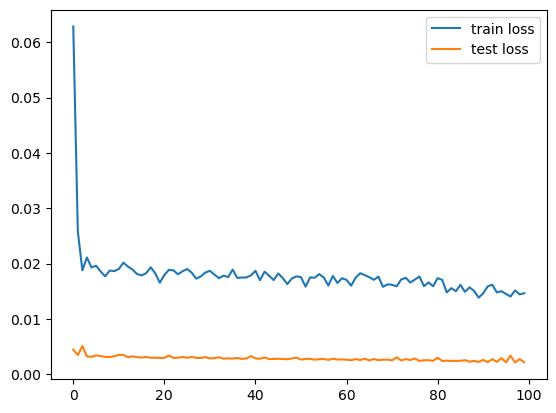

In [9]:
plt.plot(r.history['loss'], label='train loss') 
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

### Make Predictions

In [10]:
train_idx[:T+1] = False # first T+1 values are not predictable

Ptrain = model.predict(Xtrain)
Pval = model.predict(Xval)
Ptest = model.predict(Xtest)

print(Ptrain.shape, Pval.shape, Ptest.shape)

Ptrain = scaler_y.inverse_transform(Ptrain.reshape(-1, 1))
Pval = scaler_y.inverse_transform(Pval.reshape(-1, 1))
Ptest = scaler_y.inverse_transform(Ptest.reshape(-1, 1))

# needed to compute un-differenced predictions 
df['ShiftLogVolume'] = df['LogVolume'].shift(1) 
prev = df['ShiftLogVolume']

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
(94, 1) (12, 1) (12, 1)


### 1-step forecast

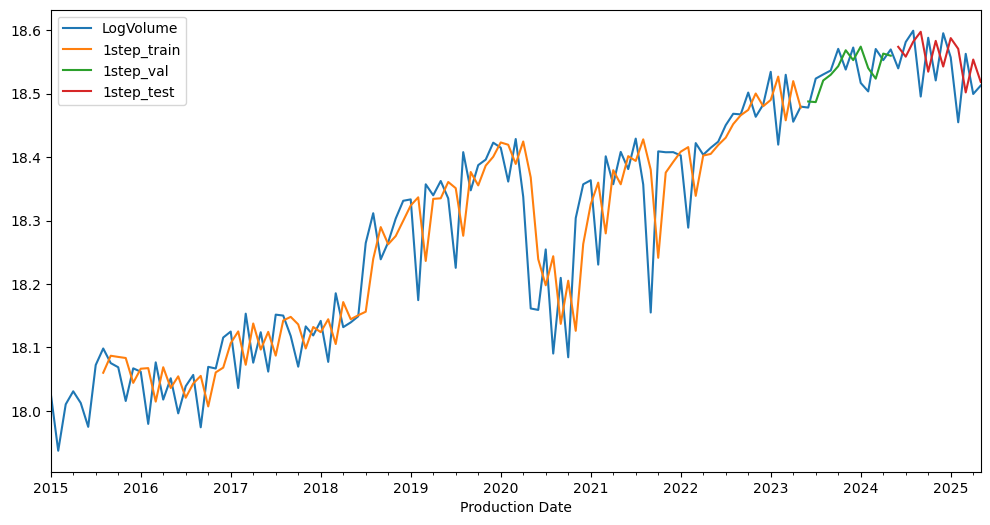

In [11]:
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain.ravel()
df.loc[val_idx, '1step_val'] = prev[val_idx] + Pval.ravel()
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest.ravel()

# plot 1-step forecast
df[['LogVolume', '1step_train', '1step_val', '1step_test']].plot(figsize=(12,6));

### Multi-step forecast

In [12]:
multistep_predictions = [] 

# first test input
last_x = Xtest[0] 

while len(multistep_predictions) < Ntest: 
    p = model.predict(last_x[np.newaxis, :, :], verbose=0)  
    p_value = p[0, 0]
    # update predictions list 
    multistep_predictions.append(p_value) 
    # make the new input 
    last_x = np.roll(last_x, -1) 
    last_x[-1, 0] = p_value

multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler_y.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten() 

# last-known validation value 
last_val = val.iloc[-1]['LogVolume']

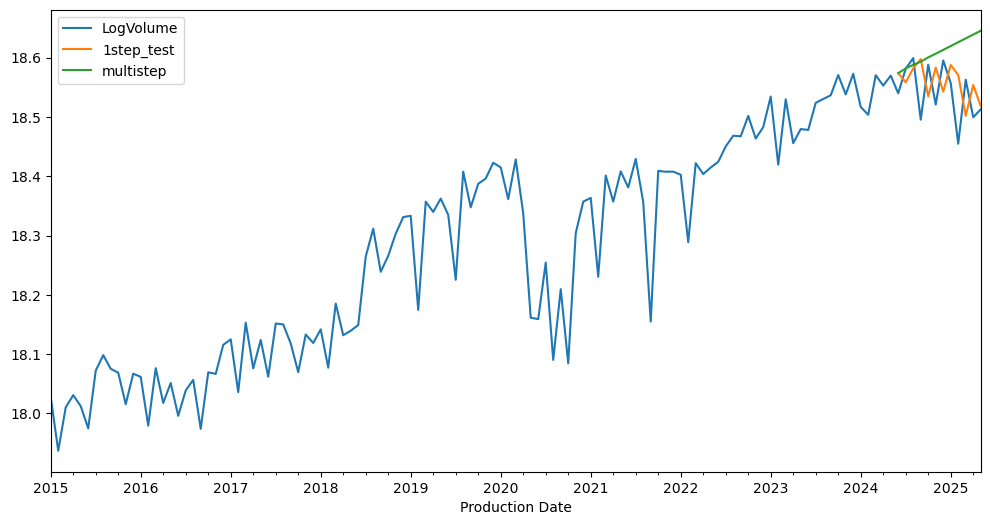

In [13]:
# multi-step forecast 
df.loc[test_idx, 'multistep'] = last_val + np.cumsum(multistep_predictions) 

df[['LogVolume', '1step_test', 'multistep']].plot(figsize=(12,6));

### Multi-output supervised dataset

In [14]:
Tx = T 
Ty = Ntest 
X = [] 
Y = [] 

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx) 
Y = np.array(Y).reshape(-1, Ty) 
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (107, 6) Y.shape (107, 12)


### Train/Validation/Test Split

In [15]:
Ntest_m = 1
Nval_m = 1

Xtrain_m, Ytrain_m = X[:-Ntest_m-Nval_m], Y[:-Ntest_m-Nval_m]
Xval_m, Yval_m = X[-Ntest_m-Nval_m:-Ntest_m], Y[-Ntest_m-Nval_m:-Ntest_m]
Xtest_m, Ytest_m = X[-Ntest_m:], Y[-Ntest_m:]

print(f"Train: {Xtrain_m.shape}, {Ytrain_m.shape}")
print(f"Val:   {Xval_m.shape}, {Yval_m.shape}")
print(f"Test:  {Xtest_m.shape}, {Ytest_m.shape}")

Train: (105, 6), (105, 12)
Val:   (1, 6), (1, 12)
Test:  (1, 6), (1, 12)


### Scaling

In [16]:
scaler_xm = MinMaxScaler(feature_range=(0, 1))
scaler_ym = MinMaxScaler(feature_range=(0, 1))

Xtrain_m = scaler_xm.fit_transform(Xtrain_m)
Xtrain_m = Xtrain_m.reshape(-1, Xtrain_m.shape[1], 1)

Xval_m = scaler_xm.transform(Xval_m)
Xval_m = Xval_m.reshape(-1, Xval_m.shape[1], 1)

Xtest_m = scaler_xm.transform(Xtest_m)
Xtest_m = Xtest_m.reshape(-1, Xtest_m.shape[1], 1)

Ytrain_m = scaler_ym.fit_transform(Ytrain_m)
Yval_m = scaler_ym.transform(Yval_m)
Ytest_m = scaler_ym.transform(Ytest_m)

### RNN

In [17]:
K.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

initializer = tf.keras.initializers.GlorotUniform(seed=SEED)

model_m = Sequential([
    Input(shape=(T, 1)),
    LSTM(50, activation='tanh', return_sequences=True,
         kernel_initializer=initializer, recurrent_initializer=initializer,
         bias_initializer='zeros'),
    Dropout(0.2, seed=SEED),
    LSTM(50, activation='tanh', return_sequences=False,
         kernel_initializer=initializer, recurrent_initializer=initializer,
         bias_initializer='zeros'),
    Dropout(0.2, seed=SEED),
    Dense(Ty, kernel_initializer=initializer, bias_initializer='zeros')
])

model_m.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=['mae']
)

# Early stopping based on validation loss
early_stop_m = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_m.summary()

r_m = model_m.fit(
    Xtrain_m, 
    Ytrain_m,
    epochs=100,
    batch_size=18,
    validation_data=(Xval_m, Yval_m),  # Use validation set
    callbacks=[early_stop_m],
    verbose=1,
    shuffle=True  # Can shuffle since sequences don't overlap in training
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │             612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,212 (121.92 KB)

 Trainable params: 31,212 (121.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 0.1114 - mae: 0.4375 - val_loss: 0.0863 - val_mae: 0.3864
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0894 - mae: 0.3832 - val_loss: 0.0623 - val_mae: 0.3189
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0624 - mae: 0.3040 - val_loss: 0.0346 - val_mae: 0.2246
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0366 - mae: 0.2155 - val_loss: 0.0174 - val_mae: 0.1540
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0270 - mae: 0.1820 - val_loss: 0.0131 - val_mae: 0.1320
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0214 - mae: 0.1592 - val_loss: 0.0138 - val_mae: 0.1383
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0216 - mae: 0.1592 - val_loss: 0.0136 - val_mae: 0.1449
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0206 - mae: 0.1588 - val_loss: 0.0121 - val_mae: 0.1427
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0197 - mae:

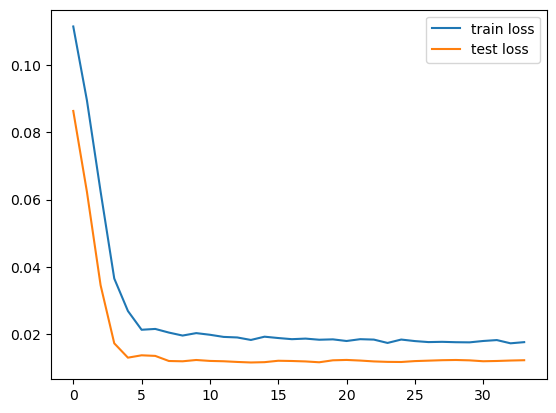

In [18]:
plt.plot(r_m.history['loss'], label='train loss') 
plt.plot(r_m.history['val_loss'], label='test loss')
plt.legend();

### Make Predictions

In [19]:
Ptrain_m = model_m.predict(Xtrain_m)
Pval_m = model_m.predict(Xval_m)
Ptest_m = model_m.predict(Xtest_m)

print(f"Ptrain_m shape: {Ptrain_m.shape}")
print(f"Pval_m shape:   {Pval_m.shape}")
print(f"Ptest_m shape:  {Ptest_m.shape}")

Ptrain_m = scaler_ym.inverse_transform(Ptrain_m)
Pval_m = scaler_ym.inverse_transform(Pval_m)
Ptest_m = scaler_ym.inverse_transform(Ptest_m)

Ptrain_m = Ptrain_m[:,0] 
Ptest_m = Ptest_m[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Ptrain_m shape: (105, 12)
Pval_m shape:   (1, 12)
Ptest_m shape:  (1, 12)


### Multi-output forecast

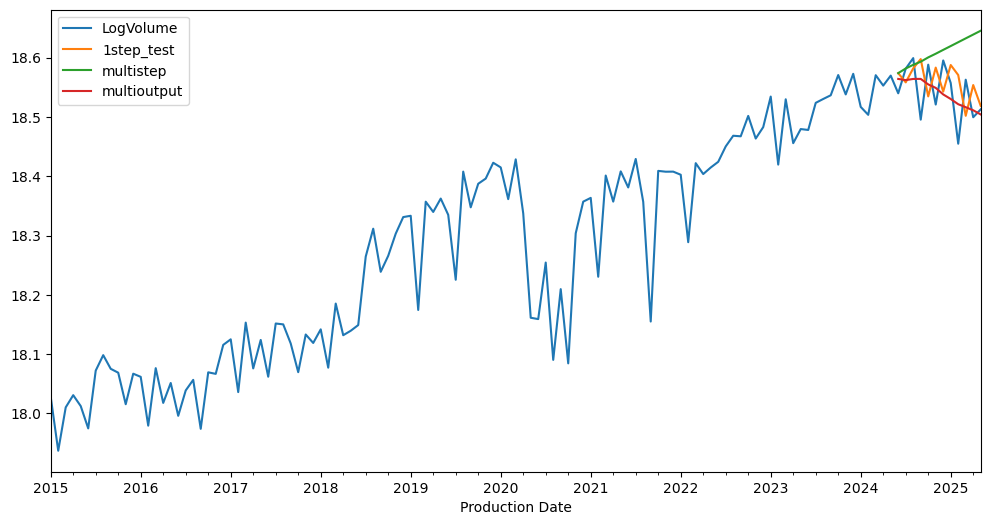

In [20]:
df.loc[test_idx, 'multioutput'] = last_val + np.cumsum(Ptest_m)

df[['LogVolume', '1step_test', 'multistep', 'multioutput']].plot(figsize=(12,6));

### Summary Plot

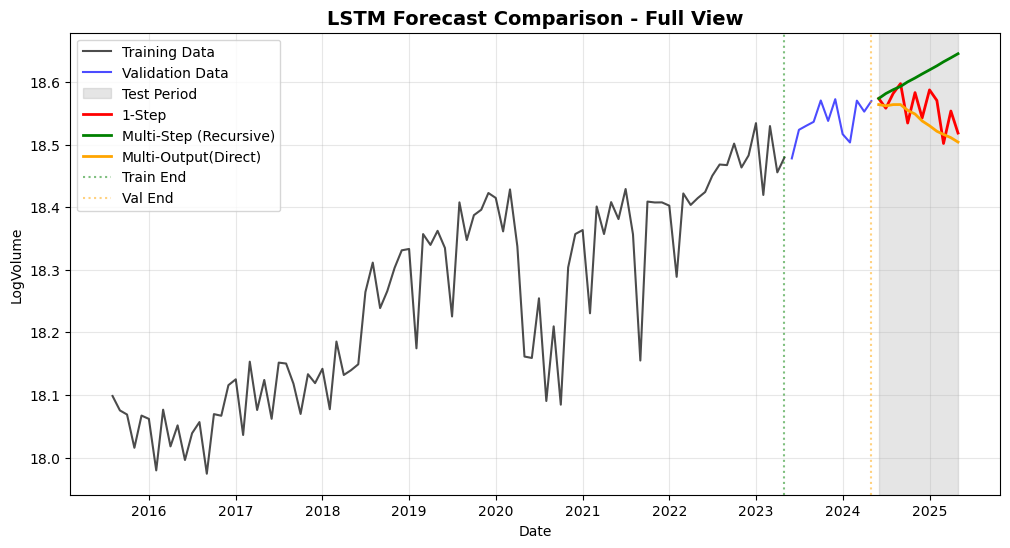

In [21]:
test_1step = df.loc[test_idx, '1step_test'].values
test_multistep = df.loc[test_idx, 'multistep'].values
test_multioutput = df.loc[test_idx, 'multioutput'].values

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, df.loc[train.index, 'LogVolume'], 'k-',label='Training Data', alpha=0.7)
ax.plot(val.index, df.loc[val.index, 'LogVolume'], 'b-',label='Validation Data', alpha=0.7) 
ax.axvspan(test.index[0], test.index[-1], alpha=0.2, color='gray', label='Test Period')
ax.plot(df.index, df['1step_test'], label='1-Step', linewidth=2, color='red')
ax.plot(df.index, df['multistep'], label='Multi-Step (Recursive)', linewidth=2, color='green') 
ax.plot(df.index, df['multioutput'], label='Multi-Output(Direct)', linewidth=2, color='orange')
ax.axvline(train.index[-1], color='green', linestyle=':', alpha=0.5, label='Train End')
ax.axvline(val.index[-1], color='orange', linestyle=':', alpha=0.5, label='Val End')
ax.set_title('LSTM Forecast Comparison - Full View', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('LogVolume')
ax.legend();
ax.grid(True, alpha=0.3)  

fig = ax.get_figure()
save_plot(fig, 'LSTM')

### Zoomed Plot

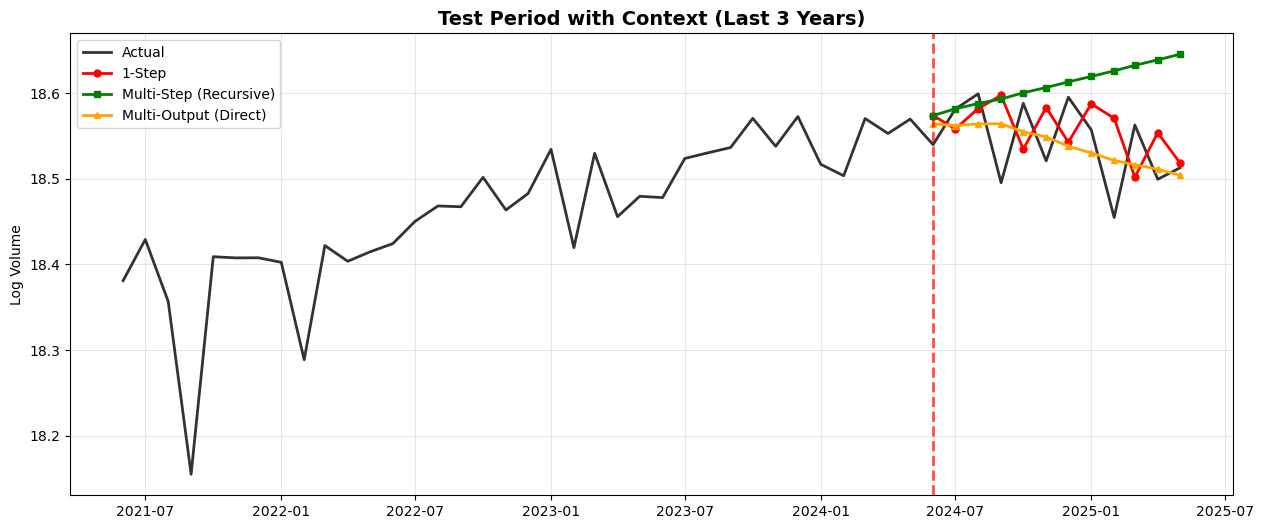

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
context_months = 36  # Show 3 years of context
context_start = test.index[0] - pd.DateOffset(months=context_months)
zoom_data = df.loc[context_start:]

ax.plot(zoom_data.index, zoom_data['LogVolume'], 'k-', 
         label='Actual', linewidth=2, alpha=0.8)
ax.plot(df.loc[test_idx].index, test_1step, 
         'ro-', label='1-Step', linewidth=2, markersize=5)
ax.plot(df.loc[test_idx].index, test_multistep, 
         'gs-', label='Multi-Step (Recursive)', linewidth=2, markersize=5)
ax.plot(df.loc[test_idx].index, test_multioutput, 
         '^-', color='orange', label='Multi-Output (Direct)', linewidth=2, markersize=5)
ax.axvline(test.index[0], color='red', linestyle='--', alpha=0.7, linewidth=2)
ax.set_title('Test Period with Context (Last 3 Years)', fontsize=14, fontweight='bold')
ax.set_ylabel('Log Volume')
ax.legend()
ax.grid(True, alpha=0.3)

### Metrics

In [23]:
print("=" * 70)
mae1 = mean_absolute_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, '1step_test'])
print('1step MAE:', mae1)
mae2 = mean_absolute_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, 'multistep'])
print('multi-step MAE:', mae2) 
mae3 = mean_absolute_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, 'multioutput'])
print('multi-output MAE:', mae3)

print("=" * 70)
mape1 = mean_absolute_percentage_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, '1step_test'])
print('1step MAPE:', mape1)
mape2 = mean_absolute_percentage_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, 'multistep'])
print('multi-step MAPE:', mape2)
mape3 = mean_absolute_percentage_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, 'multioutput'])
print('multi-output MAPE:', mape3)
 
print("=" * 70)
rmse1 = mean_squared_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, '1step_test'])
print('1step RMSE:', rmse1)
rmse2 = mean_squared_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, 'multistep'])
print('multi-step RMSE:', rmse2)
rmse3 = mean_squared_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, 'multioutput'])
print('multi-output RMSE:', rmse3)

1step MAE: 0.05098693353696978
multi-step MAE: 0.06951839747384862
multi-output MAE: 0.03551034841379656
1step MAPE: 0.0027522228645705353
multi-step MAPE: 0.0037557239077652548
multi-output MAPE: 0.00191555856335222
1step RMSE: 0.003576783229495726
multi-step RMSE: 0.00780493371719842
multi-output RMSE: 0.0016336819763996683


### Conclusion